In [28]:
import os
import pickle
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torchvision.transforms as T
from tokenizers import Tokenizer

from torchvision.io import read_image

from src.data.cv_utils import display_images, display_logits_heatmap
from src.utils import load_from_checkpoint

from src.models.CLIP_model import CLIPModule

from src.models.computer_vision.backbones.vit import ViTBaseOver16at112, ViTBaseOver32at224, ViTSmallOver16at112, ViTMicroOver14at112
from src.models.natural_language_processing.nlp_backbones import GPTSmall, GPTBase, GPTLarge

In [53]:
image_path = "data/biastest"
tokenizer_file = "src/data/nlp/tokenizers/CLIP-bpe.tokenizer.json"
img_res = 224

In [54]:
device = 'cuda:1'
use_checkpoint = False

vocab_size = 20000
clip_embedding_dim = 512
max_length = 32

text_dim_out = 512
image_dim_out = 768

TypeError: Invalid shape (3, 3024, 4032) for image data

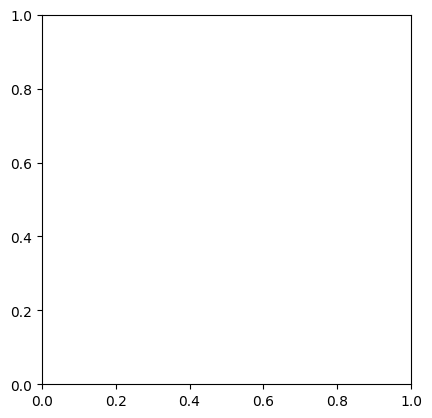

In [89]:
import cv2

image_files = [os.path.join(image_path, img) for img in os.listdir(image_path) if ".jpg" in img]

# Load the image
image = read_image(image_files[0])

# Convert the image from BGR to RGB
image = plt.imshow(image.detach().numpy())

# Display the image using matplotlib
plt.imshow(image)
plt.axis('off')  # Optional: Turn off the axis labels
plt.show()

In [82]:
def load_dataset(image_dir, img_res):
    image_files = [os.path.join(image_dir, img) for img in os.listdir(image_dir) if ".jpg" in img]
    
    text = [
        "a hand holding an iphone",
        "a papaya fruit",
        "an apple fruit",
        "a turned off TV",
        "a turned off macbook computer",
        "a piece of paper with TV writen on it",
        "a piece of paper with iPhone writen on it",
        "a piece of paper with Computer writen on it",
        "a piece of paper that says apple on it",
        "a piece of paper over a papaya"
    ]
    
    images = torch.cat([torch.unsqueeze(read_image(img), 0) for img in image_files])
    
    _, w, h = images[0].shape
    
    factor = img_res / min(w, h)
    new_width = int(w * factor)
    new_height = int(h * factor)

    images = T.Resize((new_height, new_width), antialias=True)(images)
    images = T.RandomCrop((img_res, img_res))(images)
    
    return images, text

In [83]:
def load_clip_backbone(image_encoder, text_encoder, device):
    
    image_model = None
    image_resolution = None
    if image_encoder == "B/32@224":
        image_model = ViTBaseOver32at224(dim_out=image_dim_out).to(device)
        image_resolution = 224
    if image_encoder == "B/16@112":
        image_model = ViTBaseOver16at112(dim_out=image_dim_out).to(device)
        image_resolution = 112
    if image_encoder == "S/16@112":
        image_model = ViTSmallOver16at112(dim_out=image_dim_out).to(device)
        image_resolution = 112
    if image_encoder == "M/14@112":
        image_model = ViTMicroOver14at112(dim_out=image_dim_out).to(device)
        image_resolution = 112
        
    text_model = None
    if text_encoder == "S":
        text_model = GPTSmall(dim_out=text_dim_out, vocab_size=vocab_size, max_length=max_length, use_checkpoint=use_checkpoint, device=device).to(device)
    if text_encoder == "B":
        text_model = GPTBase(dim_out=text_dim_out, vocab_size=vocab_size, max_length=max_length, use_checkpoint=use_checkpoint, device=device).to(device)
    if text_encoder == "L":
        text_model = GPTLarge(dim_out=text_dim_out, vocab_size=vocab_size, max_length=max_length, use_checkpoint=use_checkpoint, device=device).to(device)

    clip_model = CLIPModule(image_encoder=image_model, text_encoder=text_model, dim_img=image_dim_out, dim_text=text_dim_out, embedding_dim=clip_embedding_dim, temperature=0.07).to(device)
    
    return clip_model


def tokenize(tokenizer, query, max_length):
    # Encode sequence
    encoded_query = tokenizer.encode(query).ids

    # Truncate query if necessary
    encoded_query = encoded_query[:max_length-2]

    # Add end_of_sentence token [EOS]
    encoded_query += [tokenizer.token_to_id('[EOS]')]

    # Add padding to encoded sentence
    encoded_query += [0] * (max_length - len(encoded_query) - 1)

    # Add [SOS] and [EOS] tokens
    encoded_query = [tokenizer.token_to_id('[SOS]')] + encoded_query
    
    return encoded_query


def load_clip(clip_model):
    checkpointsdir = "src/models/checkpoints"
    
    if clip_model == "ViT-Base/32 @ 224px":
        clip = load_clip_backbone(image_encoder="B/32@224", text_encoder="B", device=torch.device('cpu'))
        clip, _, loss_hist = load_from_checkpoint(os.path.join(checkpointsdir, "CLIP_epoch_2_2023-06-30_01:36:39"), clip)
        
    if clip_model == "ViT-Base/16 @ 112px":
        clip = load_clip_backbone(image_encoder="B/16@112", text_encoder="B", device=torch.device('cpu'))
        clip, _, loss_hist = load_from_checkpoint(os.path.join(checkpointsdir, "CLIP_epoch_2_2023-07-09_23:50:00"), clip)
    
    return clip
    

In [84]:
def plot_image_output(image, output, text):
    # Convert the output tensor to a numpy array
    output_values = output.detach().numpy()

    # Create a list of labels for the output values
    labels = text
    
    # Sort the output values and labels in descending order
    sorted_indices = np.argsort(output_values)[::-1]
    output_values = output_values[sorted_indices]
    labels = [labels[i] for i in sorted_indices]

    # Plot the image and the output values side by side
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 8))

    # Plot the image
    ax1.imshow(image)
    ax1.axis('off')
    ax1.set_title('Image')

    # Plot the output values in a horizontal bar plot
    y = np.arange(len(output_values))
    bars = ax2.barh(y, output_values)
    ax2.set_yticks(y)
    ax2.set_yticklabels(labels)
    ax2.set_xlabel('Value')
    ax2.set_ylabel('Label')
    ax2.set_title('Output Values')

    # Highlight the largest value
    largest_index = np.argmax(output_values)
    bars[largest_index].set_color('red')

    plt.tight_layout()
    plt.show()

In [85]:
images, text = load_dataset(image_path, img_res)

3 4


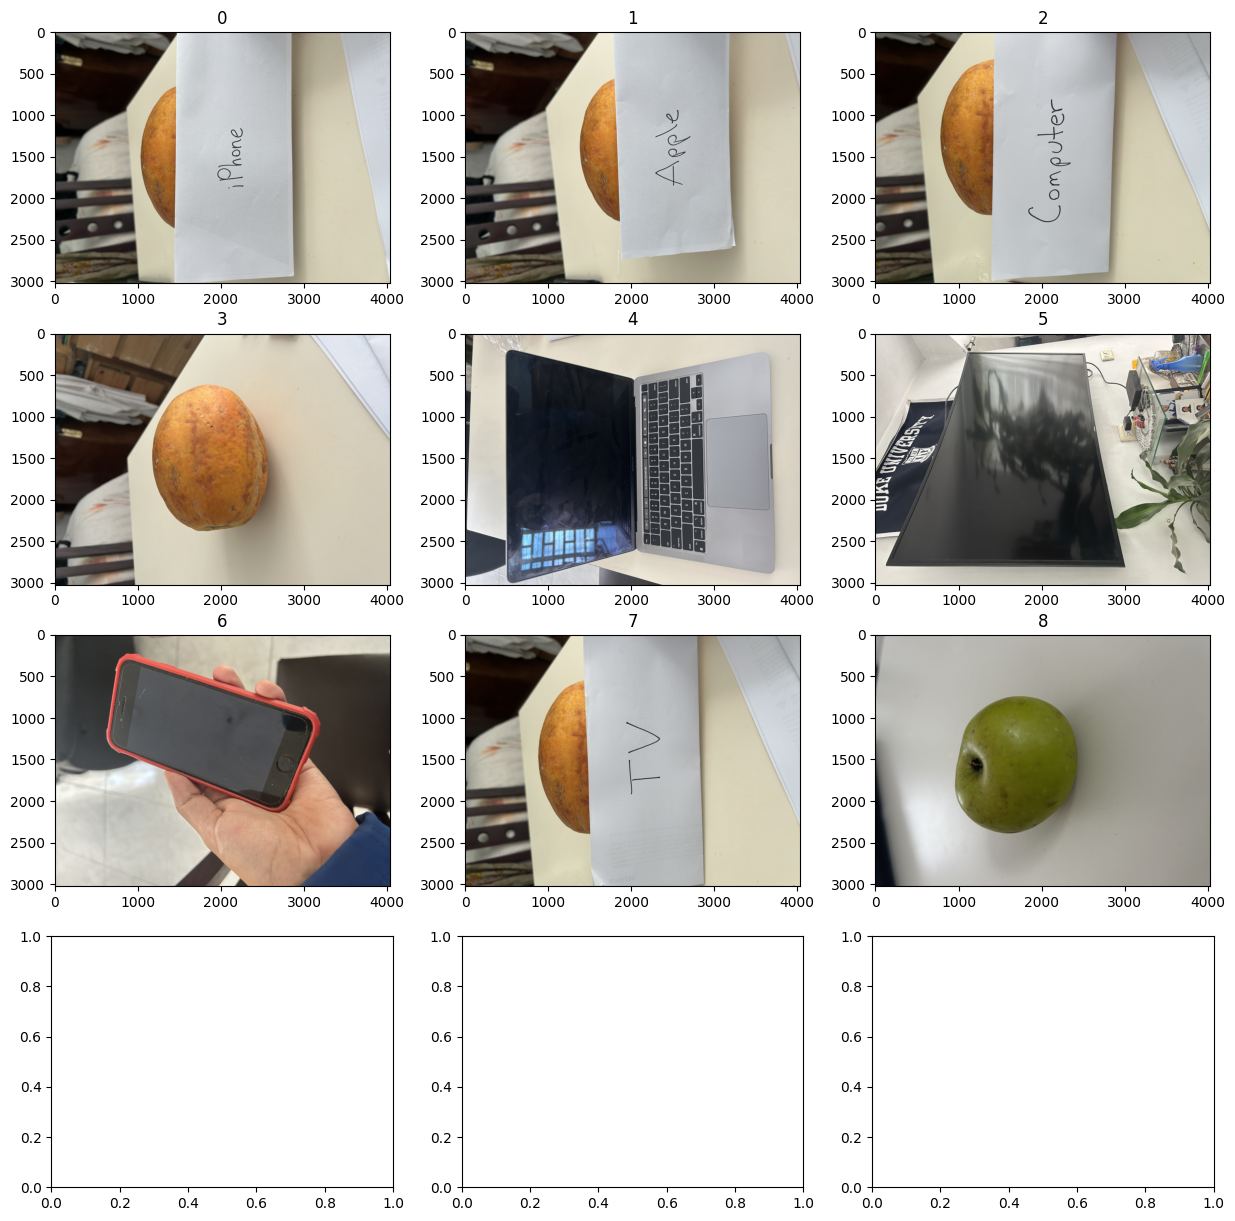

In [86]:
display_images(images, [f"{i}" for i in range(len(images))])

In [22]:
clip_base_224 = load_clip("ViT-Base/32 @ 224px")
print("CLIP Base Parameters:", np.sum([ np.prod(x.shape) for x in clip_base_224.parameters() ]))
print(type(clip_base_224))

CLIP successfully loaded from src/models/checkpoints/CLIP_epoch_2_2023-06-30_01:36:39
CLIP Base Parameters: 161361920
<class 'src.models.CLIP_model.CLIPModule'>


In [70]:
tokenizer = Tokenizer.from_file(tokenizer_file)
tokens = torch.Tensor([tokenize(tokenizer, x, max_length) for x in text]).to(dtype=torch.int)

In [71]:
img_encoding, txt_encoding = clip_base_224.img_encoder(images.to(dtype=torch.float)), clip_base_224.txt_encoder(tokens)

logits_img = img_encoding @ txt_encoding.t()

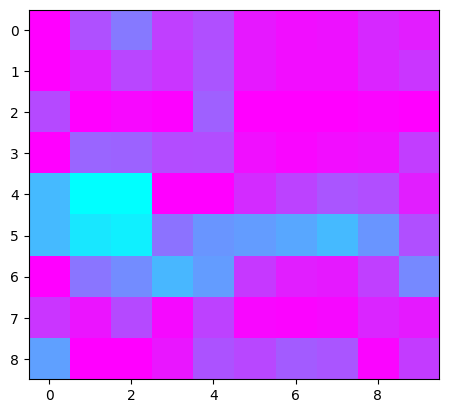

In [72]:
plt.imshow(logits_img.detach().numpy(), vmin=0, vmax=0.3, cmap='cool')
plt.show()

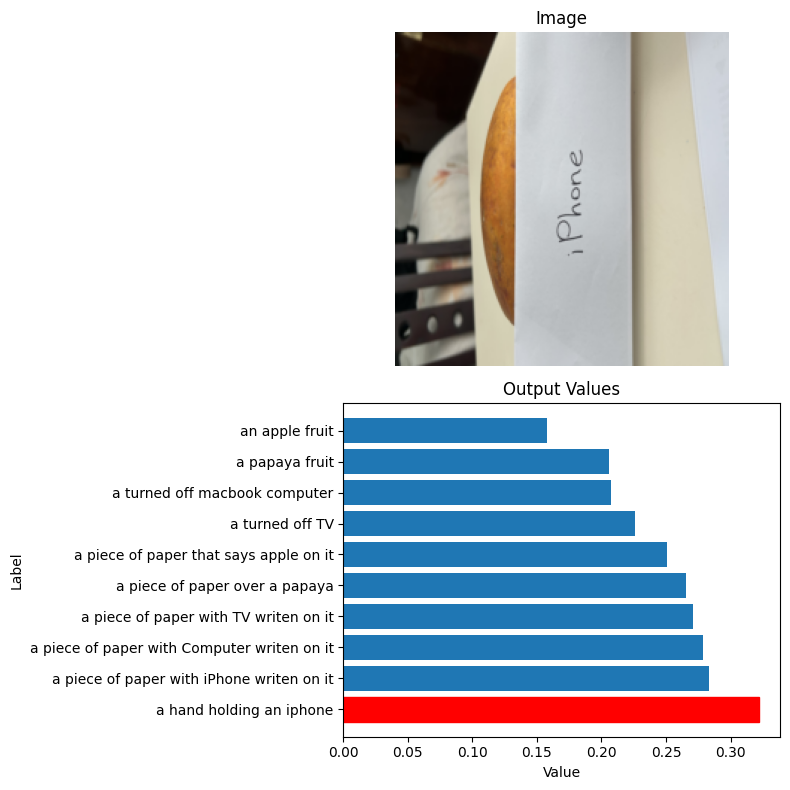

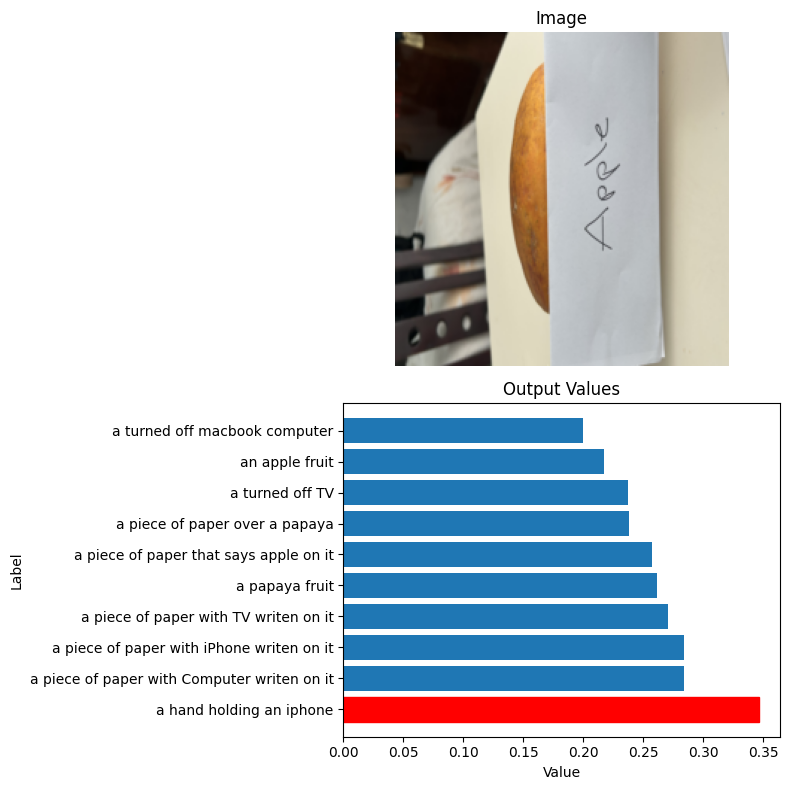

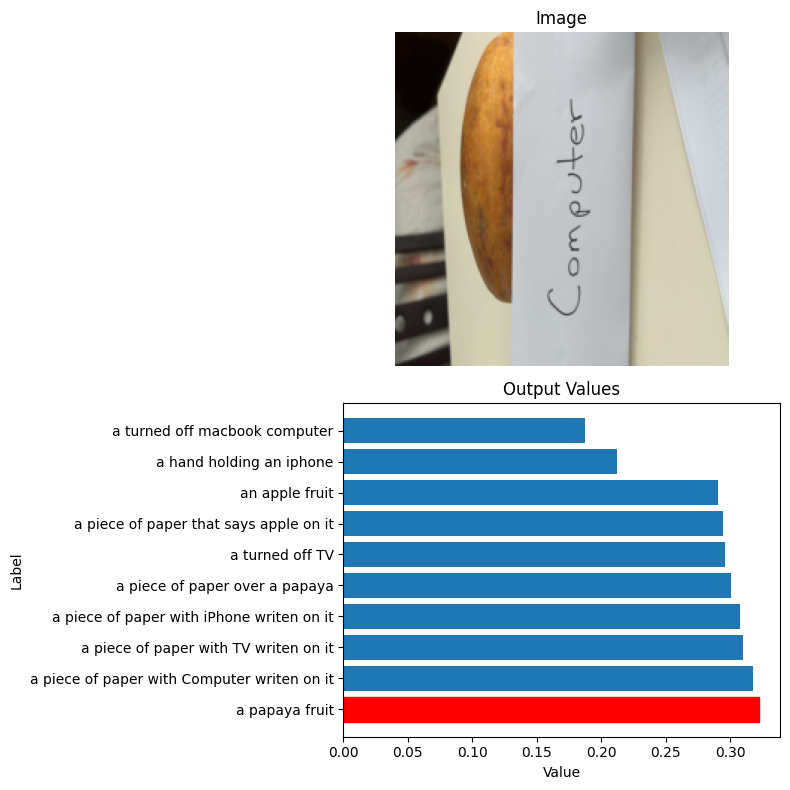

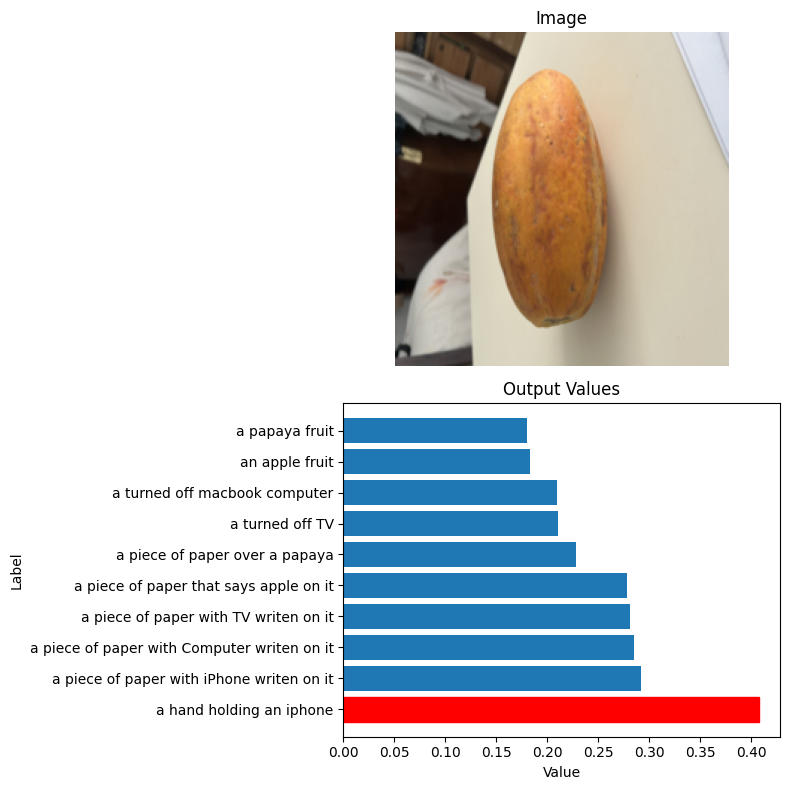

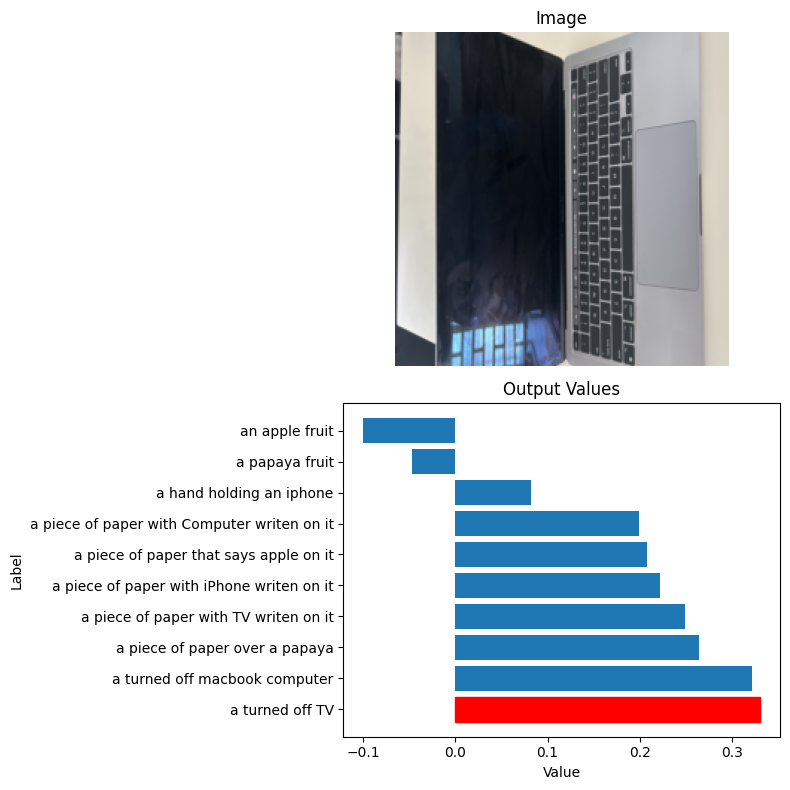

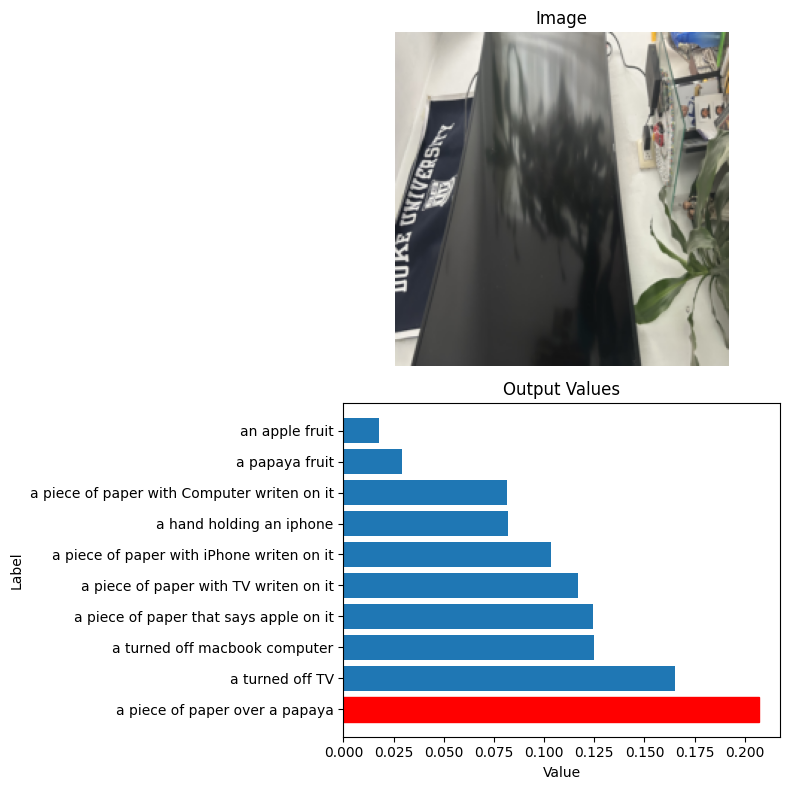

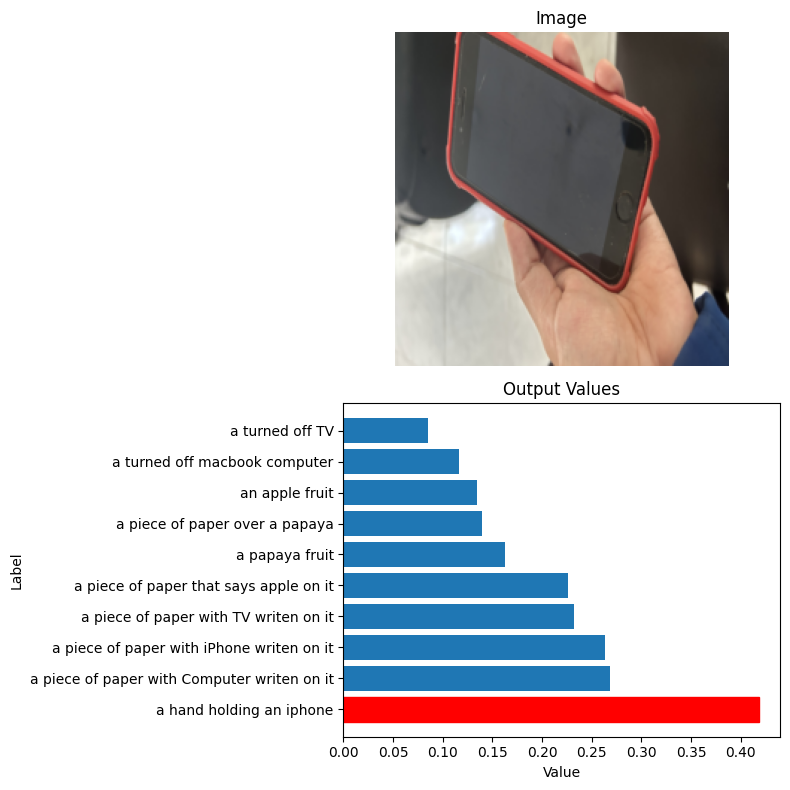

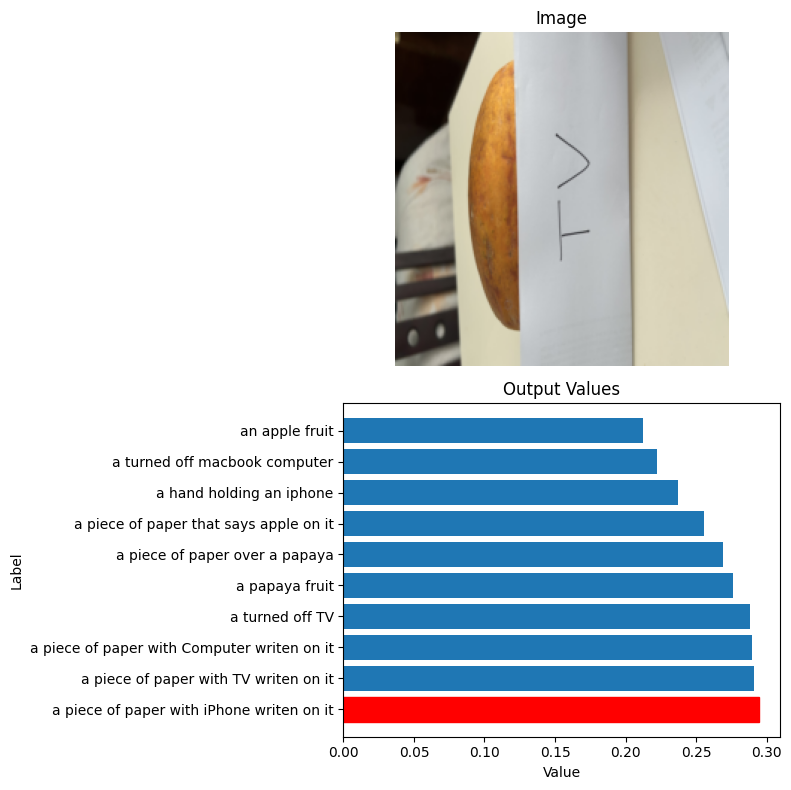

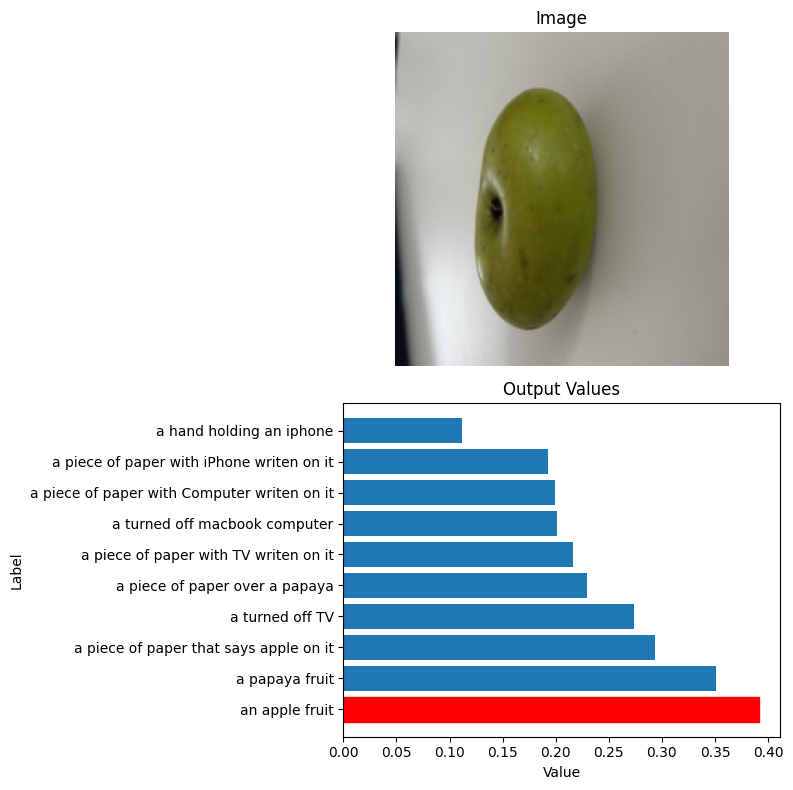

In [73]:
# display_logits_heatmap(logits_img.detach().numpy(), [img.permute(1, 2, 0) for img in images], text)

for i, img in enumerate(images):
    plot_image_output(img.permute(1, 2, 0), logits_img[i, :], text)